# **Task 1**

The classification problem that I attempted to solve in the previous assignment was to predict tightening of Federal Reserve monetary policy. I defined a binary classification task to determine whether or not the Federal Reserve would increase the Federal Funds Rate on any given day based on the previous day's macroeconomic environment.

One notable flaw discussed in the conclusion to the previous assignment was my lack of filtering the dates to only include Federal Open Market Committee meetings, which is when the overwhelming majority of rate changes have occurred historically. Leaving the macroeconomic data for other dates created an immense class imbalance that led to a majority-class strategy being converged upon defacto.

As such, I believe it would be much more useful to refine the objective to define a binary classification task to determine whether or not the Federal Reserve will increase the Federal Funds Rate at an FOMC meeting based on the economy relative to the previous FOMC meeting's macroeconomic environment.

Prior to implementing the decision tree classfier, I will perform slightly modified preprocessing on the [US Federal Reserve Daily Macroeconomic Indicators](https://www.kaggle.com/datasets/halilaka/us-federal-reserve-daily-macroeconomic-indicators) dataset compared to the previous assignment.

In [12]:
import os
import kagglehub

path_macro = kagglehub.dataset_download("halilaka/us-federal-reserve-daily-macroeconomic-indicators")

print("Path to dataset files:", path_macro)
file_path_macro = os.path.join(path_macro, "us_federal_reserve_daily_indicators.csv")

Using Colab cache for faster access to the 'us-federal-reserve-daily-macroeconomic-indicators' dataset.
Path to dataset files: /kaggle/input/us-federal-reserve-daily-macroeconomic-indicators


In addition to filtering for only FOMC meeting dates, which will be handled by keeping data for dates on which a Federal Funds Rate change occurred (as this will allow for the rare rate changes on non-FOMC meetings to be captured as well), it would be logical to alter the features so that they track changes in macroeconomic conditions between each meeting. This will be particularly useful given that decisions are to be made to predict test points rather than being predicted by parameter weightings.

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv(file_path_macro)

# All columns
print("Before preprocessing:", df.columns, len(df.columns))

# Convert the dates to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Calculate inflation rate based on yearly change in the CPI
df['inflation_rate_yoy'] = df['cpi'].pct_change(periods=365)
# Drop the NaNs created for first-year data
df = df.dropna(subset=['inflation_rate_yoy'])

# Add target column to identify if a rate hike occurred
# df['rate_hike_occurred'] = np.where(df['fed_funds_rate'].diff().shift(-1) > 0, 1, 0)
df['rate_hike_occurred'] = np.where(df['fed_funds_rate'].diff() > 0, 1, 0)

# Filter for only dates when FOMC meetings occurred
# The logic is to only keep days where the rate changed based on the
# fact that rarely does a rate change occur otherwise
df_fomc = df[df['fed_funds_rate'].diff() != 0].copy()

df_fomc = df_fomc.drop(columns=['fed_funds_rate'])
# Drop sofr_rate as many of its entries are null
df_fomc = df_fomc.drop(columns=['sofr_rate'])

# Features to find meeting-over-meetings changes
features_to_delta = [
    'inflation_rate_yoy',
    'unemployment_rate',
    'consumer_sentiment',
    'housing_starts',
    'treasury_10y'
]

for col in features_to_delta:
    df_fomc[f'{col}_delta'] = df_fomc[col].diff()
# Final refined feature (and target column) list
refined_with_deltas = [f'{col}_delta' for col in features_to_delta]

# Drop rows with null values
df_final = df_fomc.dropna(subset=refined_with_deltas + ['rate_hike_occurred'])
# Only keep desired columns
df_final = df_final[refined_with_deltas + ['rate_hike_occurred']].copy()

# Remaining features
print("Post preprocessing:", df_final.columns, len(df_final.columns))

Before preprocessing: Index(['date', 'cpi', 'fed_funds_rate', 'unemployment_rate',
       'consumer_sentiment', 'treasury_3m', 'treasury_1y', 'treasury_10y',
       'sofr_rate', 'money_supply_m2', 'real_gdp', 'industrial_production',
       'housing_starts', 'retail_sales', 'mortgage_30y'],
      dtype='object') 15
Post preprocessing: Index(['inflation_rate_yoy_delta', 'unemployment_rate_delta',
       'consumer_sentiment_delta', 'housing_starts_delta',
       'treasury_10y_delta', 'rate_hike_occurred'],
      dtype='object') 6


In [14]:
print("Data points:", len(df_final))
print("Class breakdown:\n", df_final['rate_hike_occurred'].value_counts())

Data points: 337
Class breakdown:
 rate_hike_occurred
1    186
0    151
Name: count, dtype: int64


The classes are now significantly more balanced relative to the class split in the previous assignment.

In [15]:
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = df_final[refined_with_deltas]
y = df_final['rate_hike_occurred']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

The data is split such that 80% of the points are trained on and 20% are left for testing. The argument `stratify=y` ensures that both sets have the same percentage of hikes.

As for implementing the decision tree, using at least three different parameter settings, I believe it would be most practical to make use of `sklearn`'s `DecisionTreeClassifier`. The specific parameter values for max depth can be chosen to provide a contrast in how a model handles the complexity and variance inherent in the macroeconomic data. Having a max depth of two for a shallow tree to force the model to prioritize only the most influential economic indicators will result in a highly interpretable flowchart that avoids over-reacting to small fluctuations. As for a medium tree, a max depth of five can serve to show balance that allows the model to capture non-linear interactions, such as how a specific unemployment shift might only lead to a hike if inflation is also rising, without branching so deep that generalization is lost. Setting the deep tree to have no predefined max depth allows the tree to grow until every leaf demonstrates overfitting; this variant should have complete accuracy on the training data, but will likely not perform as well on the testing data.

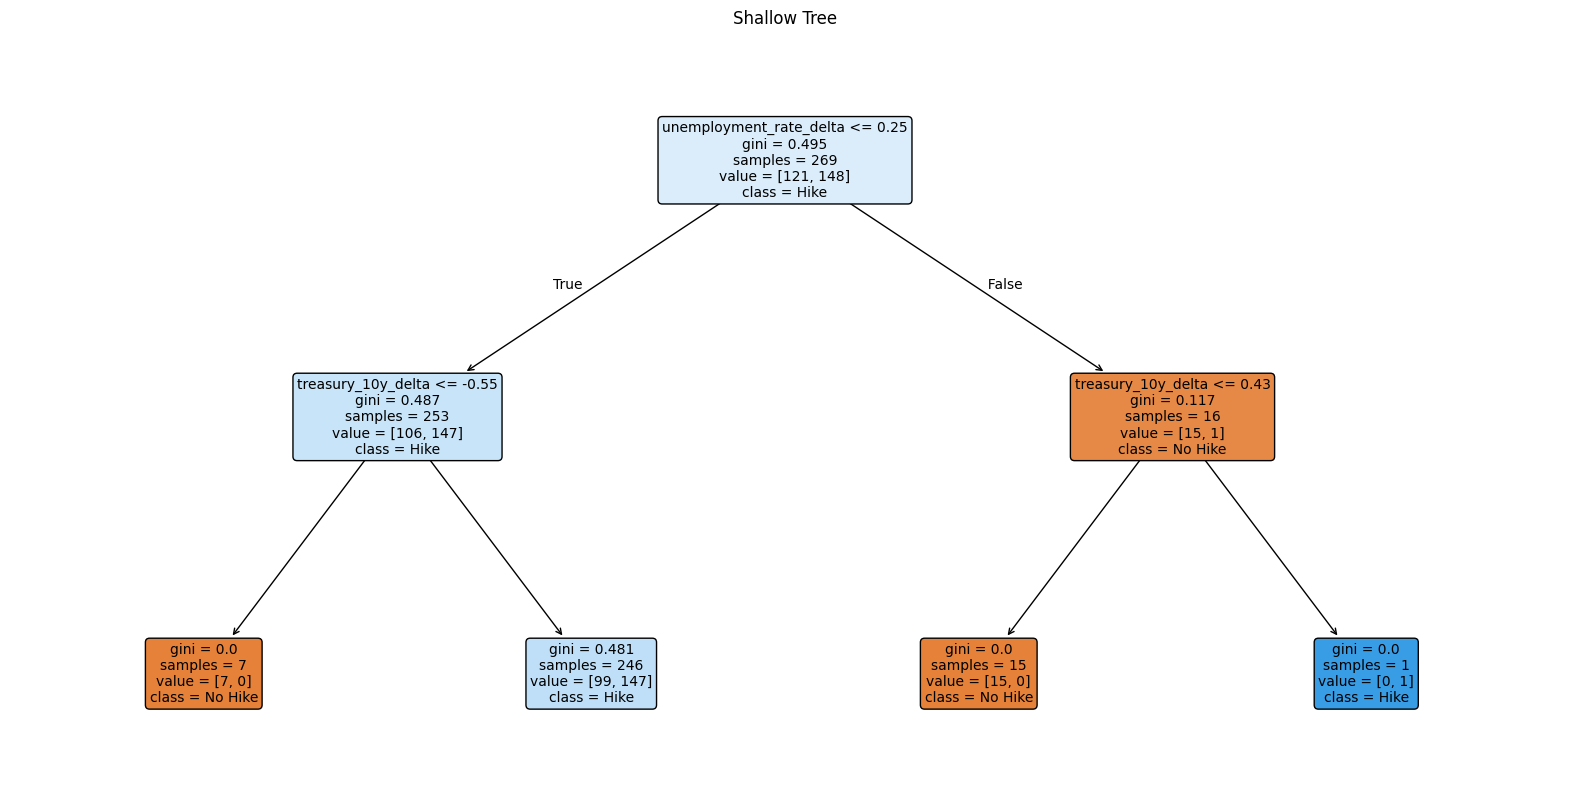

Shallow Tree - Train Accuracy: 0.63
Shallow Tree - Test Accuracy: 0.60



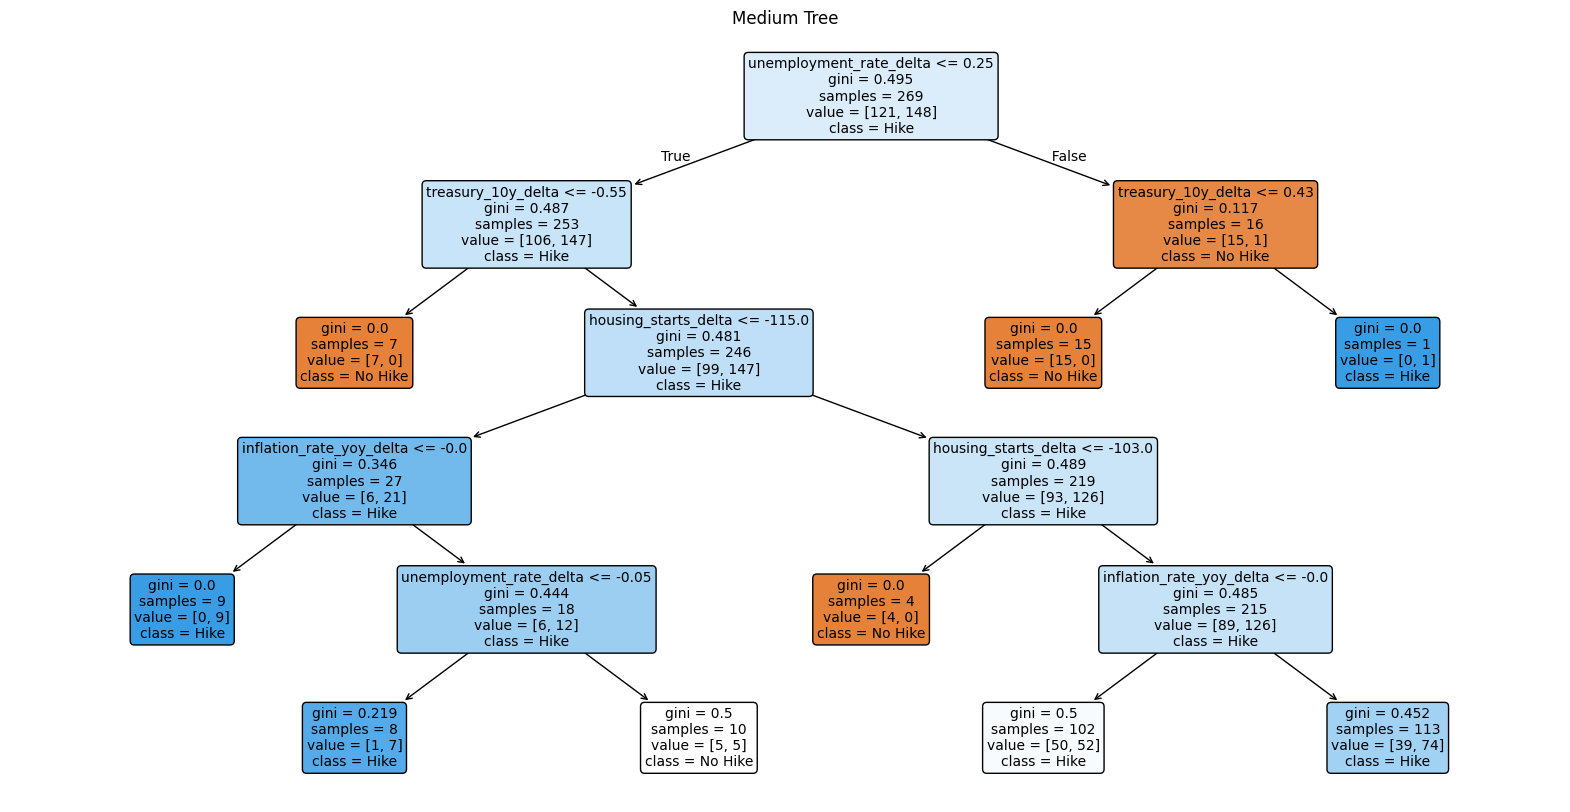

Medium Tree - Train Accuracy: 0.65
Medium Tree - Test Accuracy: 0.59



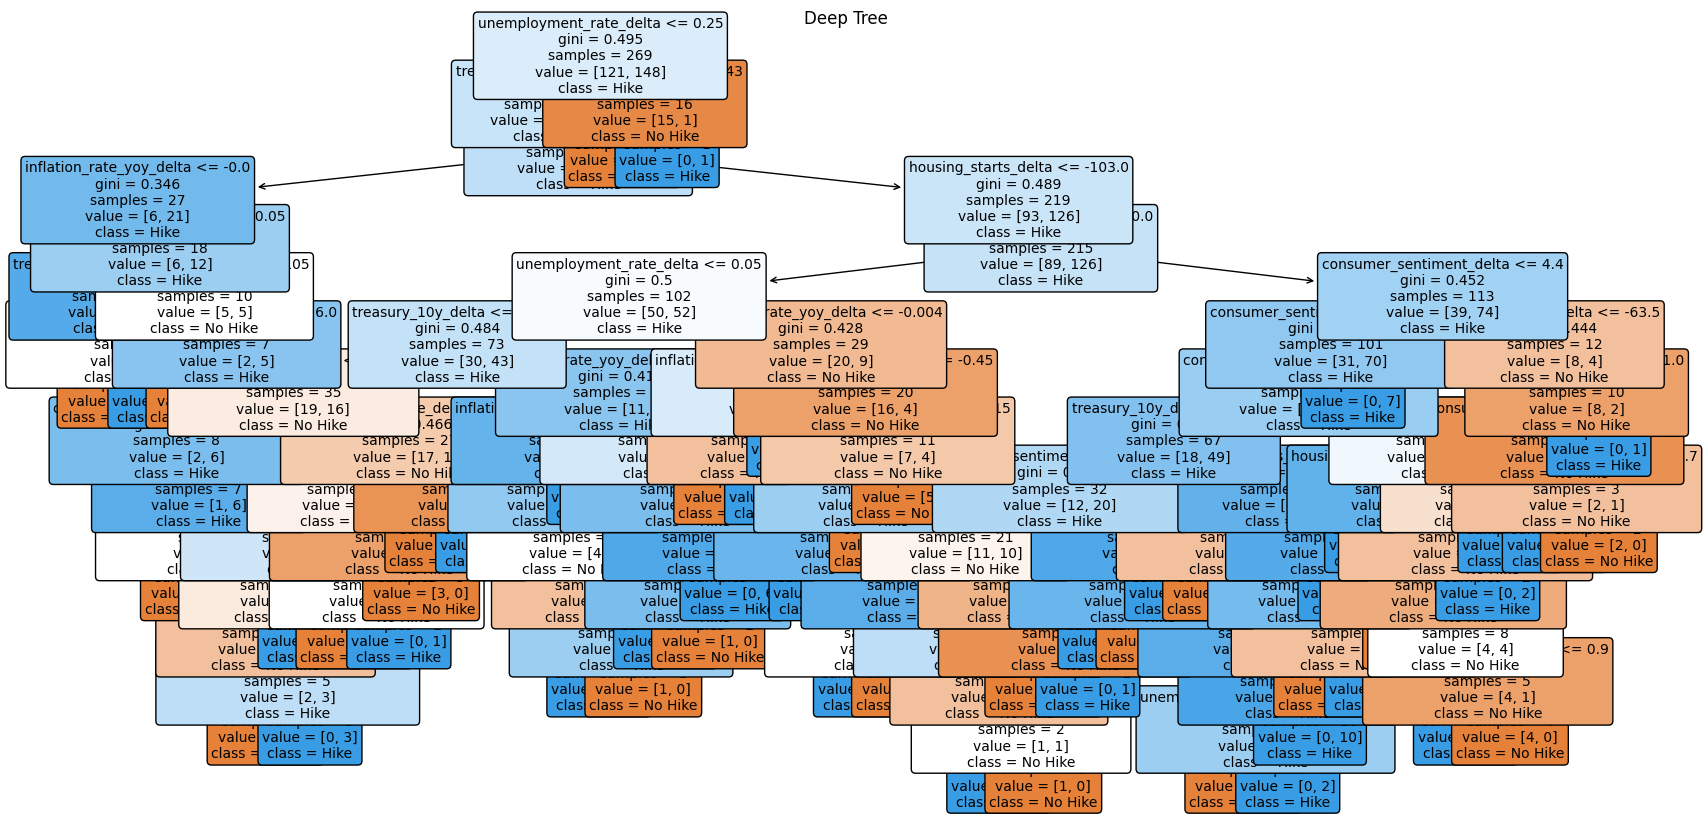

Deep Tree - Train Accuracy: 1.00
Deep Tree - Test Accuracy: 0.56



In [16]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Settings to visualize depth impact
settings = [
    {'max_depth': 2, 'title': 'Shallow Tree'},
    {'max_depth': 5, 'title': 'Medium Tree'},
    {'max_depth': None, 'title': 'Deep Tree'}
]

# Iterate through settings and plot
for s in settings:
    clf = DecisionTreeClassifier(max_depth=s['max_depth'], random_state=42)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(20,10))
    plot_tree(clf,
              feature_names=refined_with_deltas,
              class_names=['No Hike', 'Hike'],
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title(s['title'])
    plt.show()

    # Output accuracy to see the complexity tradeoff
    print(f"{s['title']} - Train Accuracy: {clf.score(X_train, y_train):.2f}")
    print(f"{s['title']} - Test Accuracy: {clf.score(X_test, y_test):.2f}\n")

The results reveal, as expected, an overfitting phenomenon, where increasing the model complexity leads to a decline in generalization. While the shallow tree and medium tree maintain relatively consistent performance between training and testing, with respective test accuracies of 0.60 and 0.59, they suffer from high bias, meaning they are likely too simple to capture the full nuances of the Federal Reserve's logic. In contrast, the deep tree (which evidently has far more than six levels) achieves a perfect training accuracy of 1.00, indicating it has successfully partitioned every historical meeting in the dataset until the Gini impurity is zero. This complexity, however, results in high variance; the model memorizes unique historical anomalies rather than learning generalizable patterns, causing its test accuracy to drop to its lowest point of 0.56. Ultimately, the shallow tree's focus on the most critical macroeconomic signals, like the unemployment rate delta, proves more instructive for future predictions than the highly specific decision paths found in the unconstrained deep model.

Sensitivity analysis is a diagnostic tool used to determine how the uncertainty in a model's output can be assigned to different sources of uncertainty in its inputs. In machine learning context, it is often performed using the one-at-a-time approach, which involves perturbing a single input variable by a small increment while holding all other features constant to observe the shift in the model's decision boundary. This process allows identification features that are most influential to a prediction and to assess the robustness of the model. For instance, if a minor change in a variable like inflation doesn't flip a "Hike" to a "No Hike," then the model is considered stable against minor statistical noise. Sensitivity analysis bridges the gap between a black-box prediction and an interpretable decision, providing a measure of how much a model relies on specific data points to reach its conclusion.

Sources: https://medium.com/@einat_93627/understand-your-black-box-model-using-sensitivity-analysis-practical-guide-ef6ac4175e55, https://www.mathworks.com/help/sldo/ug/what-is-sensitivity-analysis.html

Original prediction for sample: Hike


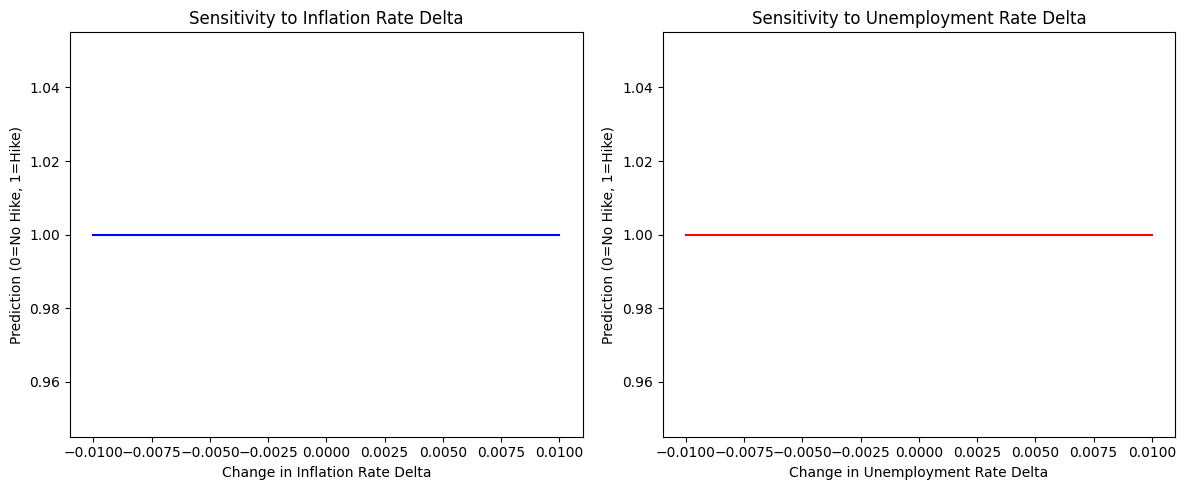

In [17]:
# Select the model and a baseline sample
clf_medium = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)
# Copy the sample so that the inital values are not changed
baseline_sample = X_test.iloc[[0]].copy()
original_pred = clf_medium.predict(baseline_sample)[0]

print(f"Original prediction for sample: {'Hike' if original_pred == 1 else 'No Hike'}")

# Range for perturbation (1% percent change with 100 evenly-spaced intervals)
perturbation_range = np.linspace(-0.01, 0.01, 100)

def perform_sa(feature_name):
    predictions = []

    for val in perturbation_range:
        test_sample = baseline_sample.copy()
        test_sample[feature_name] += val

        predictions.append(clf_medium.predict(test_sample)[0])
    return predictions

# Analyze inflation and unemployment features
inf_sens = perform_sa('inflation_rate_yoy_delta')
unemp_sens = perform_sa('unemployment_rate_delta')

# Plot the sensitivity
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(perturbation_range, inf_sens, color='blue')
plt.title('Sensitivity to Inflation Rate Delta')
plt.xlabel('Change in Inflation Rate Delta')
plt.ylabel('Prediction (0=No Hike, 1=Hike)')

plt.subplot(1, 2, 2)
plt.plot(perturbation_range, unemp_sens, color='red')
plt.title('Sensitivity to Unemployment Rate Delta')
plt.xlabel('Change in Unemployment Rate Delta')
plt.ylabel('Prediction (0=No Hike, 1=Hike)')

plt.tight_layout()
plt.show()

The sensitivity analysis assesses the stability of the medium tree's prediction by applying the one-at-a-time method specifically to the `inflation_rate_yoy_delta` and `unemployment_rate_delta` features. Since these features represent the meeting-over-meeting change in economic indicators, the analysis effectively measures how the model reacts to shifts in economic momentum rather than static levels. The resulting flat horizontal lines at a value of 1.0 indicate that the model's "Rate Hike" prediction is strong for the selected sample, remaining unchanged even when these deltas are perturbed by $\pm1\%$. This lack of a "step" or jump in the output signifies that the baseline sample resides within a stable decision region, suggesting that the "Hike" classification is driven by a multi-factor consensus that is resilient to minor revisions or volatility in the momentum of each of these indicators.

# **Task 2**

I will be implementing random forest for bagging and AdaBoost for boosting.

While a standard bagged decision tree simply averages independent trees, random forest introduces feature randomness, forcing trees to decorrelate by only considering a random subset of features at each split; this is particularly valuable for this macroeconomic dataset, as it prevents a single dominant feature (e.g. unemployment) from dictating the logic of every tree in the ensemble.

For the boosting category, I prefer AdaBoost over variants like gradient boosting or XGBoost for this use case due to its unique weighting mechanism and the size of the dataset. While gradient boosting focuses on minimizing residual errors through gradient descent, AdaBoost works by iteratively increasing the weight of, in this case, the specific historical policy shifts that the model missed, effectively forcing the next stump to focus on the economic anomalies in the 337-row set. While XGBoost could serve well here, AdaBoost avoids the significant risk of overfitting that often accompanies the highly complex objective functions and hyperparameter tuning required for XGBoost on limited data.

This combination allows for a comparison of a variance-reducing method trained in parallel (random forest) against a bias-reducing method trained in sequence (AdaBoost) to see which approach better captures the Fed's decision-making patterns.

Sources: https://www.kaggle.com/discussions/questions-and-answers/469560, https://www.geeksforgeeks.org/machine-learning/gradientboosting-vs-adaboost-vs-xgboost-vs-catboost-vs-lightgbm/

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pandas as pd

# Initialize models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42)
}
# Evaluation metrics
scoring_metrics = ['accuracy', 'precision', 'f1']

fold_counts = [5, 10, 15]
results_list = []

for k in fold_counts:
    # Stratified to ensure 186/151 hike/hold ratio in every fold
    strat_k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=strat_k_fold, scoring=scoring_metrics)

        results_list.append({
            'Algorithm': name,
            'Folds': k,
            'Avg Accuracy': cv_results['test_accuracy'].mean(),
            'Avg Precision': cv_results['test_precision'].mean(),
            'Avg F1': cv_results['test_f1'].mean()
        })
# Final results table
ensemble_summary = pd.DataFrame(results_list)

print(ensemble_summary)

      Algorithm  Folds  Avg Accuracy  Avg Precision    Avg F1
0  RandomForest      5      0.531431       0.563880  0.602947
1      AdaBoost      5      0.566725       0.590309  0.632355
2  RandomForest     10      0.516488       0.551982  0.582273
3      AdaBoost     10      0.579144       0.589512  0.661345
4  RandomForest     15      0.561528       0.596187  0.618301
5      AdaBoost     15      0.582082       0.595423  0.668251


The transition from individual decision trees to ensemble methods demonstrates how different architectural strategies handle the inherent noise in macroeconomic momentum data. Across all k-fold configurations, the boosting algorithm (AdaBoost) consistently outperformed the bagging algorithm (random forest), achieving a peak Avg F1-score of 0.668 at 15 folds. This superior performance is largely due to AdaBoost's sequential nature; by iteratively increasing the weight of previously misclassified nuanced economic anomalies, the algorithm "drills" into the complex thresholds of the five delta features that represent the Federal Reserve's more nuanced decisions. In contrast, random forest's parallel approach of averaging independent trees built with feature randomness resulted in a lower Avg Accuracy (0.51-0.56), likely because the random exclusion of a dominant primary driver, such as a sharp shift in the 10Y Treasury delta, hindered its ability to find a stable signal in a relatively small 337-row dataset.

The 15-fold setup likely performed best (achieving a peak 0.668 F1-score) specifically because it provided the largest possible training window. In this configuration, the ensembles had ~314 rows to learn from in each fold, compared to only 269 rows in a 5-fold split. For complex models like AdaBoost that rely on correcting specific historical errors, the extra 45 rows of data act as critical lessons that allow the model to refine its decision boundaries around the more subtle economic deltas.

The performance ranking remained remarkably stable across all three metrics, with AdaBoost maintaining the lead in accuracy, precision, and F1-score regardless of the fold count (with one exception). Notably, both models yielded Avg F1-scores that were consistently higher than their raw Avg Accuracy; at 15 folds, for instance, AdaBoost's 0.668 F1-score compared to its 0.582 accuracy highlights a high recall. This suggests the ensembles are particularly effective at detecting actual rate hikes even if they occasionally produce false positives. Further, to complement the logic with respect to increasing the folds, the improvement in scores as $k$ increased from 5 to 15 underscores the importance of training data volume; as each model was exposed to a larger percentage of the dataset (up to ~93%), it gained the necessary resolution to identify the subtle economic momentum shifts that trigger policy changes.

With respect to the one exception in the performance of AdaBoost exceeding that of random forest, it is likely that with 15 folds, the random forest had enough historical context to become more "conservative" in that it likely stopped flagging certain noisy economic shifts as hikes, thereby reducing false positives and raising its precision.

# **Task 3**

For this analysis of the bagging and boosting algorithms, it is likely best to select one specific test fold from the 15-fold cross-validation, as the performance metrics were greatest for 15 folds. From the three decision trees implemented, I will select the medium tree as it produced the highest in-sample accuracy.

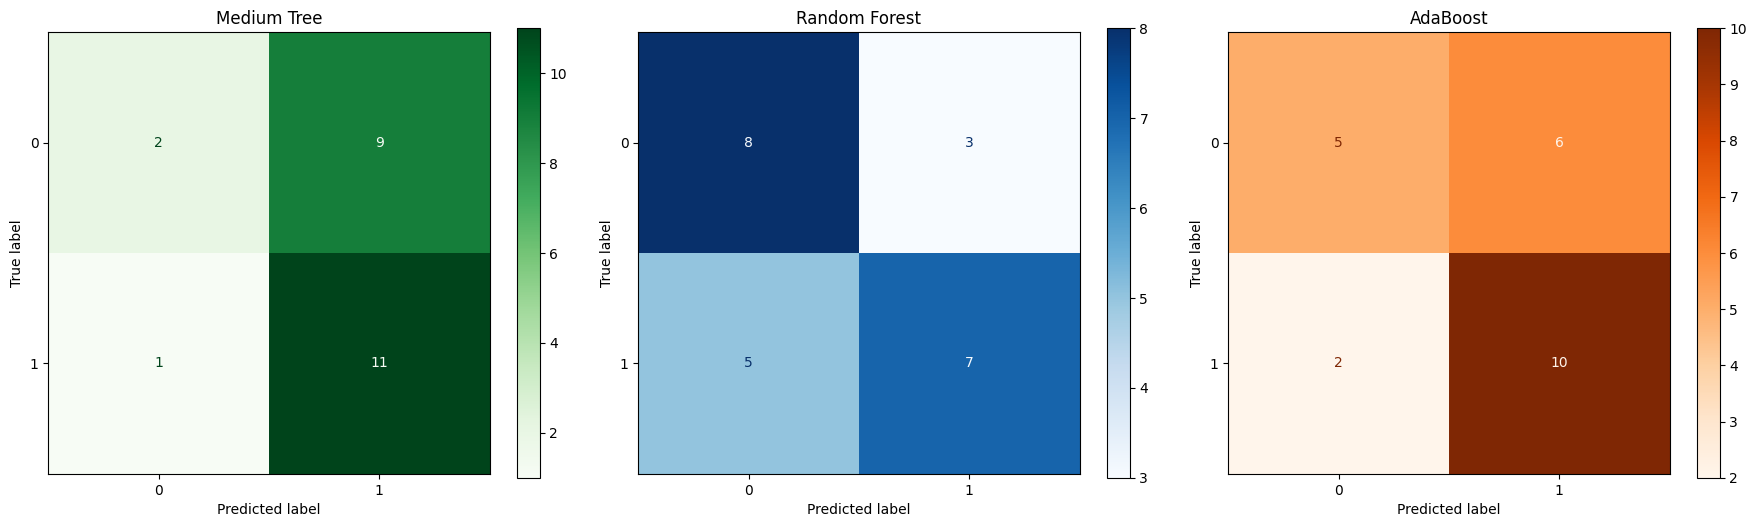

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 15-fold object
strat_k_fold = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

# Grab the indices for the first fold
train_idx, test_idx = next(strat_k_fold.split(X, y))

# Create the specific training/testing sets for this fold
X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

# Train the models on this specific 15-fold slice
rf_model = models['RandomForest'].fit(X_train_fold, y_train_fold)
ada_model = models['AdaBoost'].fit(X_train_fold, y_train_fold)
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train_fold, y_train_fold)

# Plot the comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Decision Tree Matrix
ConfusionMatrixDisplay.from_estimator(tree_model, X_test_fold, y_test_fold, ax=axes[0], cmap='Greens')
axes[0].set_title('Medium Tree')

# Random Forest Matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test_fold, y_test_fold, ax=axes[1], cmap='Blues')
axes[1].set_title('Random Forest')

# AdaBoost Matrix
ConfusionMatrixDisplay.from_estimator(ada_model, X_test_fold, y_test_fold, ax=axes[2], cmap='Oranges')
axes[2].set_title('AdaBoost')

plt.tight_layout()
plt.show()

To ensure a controlled comparison, the medium tree was retrained on the same 15-fold training slice as the random forest and AdaBoost models. This allows for a direct evaluation of the effectiveness of ensemble methods over the single tree while keeping the volume of training data (~314 samples) constant across all three implementations.

The confusion matrices for a single 15-fold test slice (containing approximately 23 samples) exhibit prediction accuracies on the test points approximately consistent with the accuracies reported previously. The medium tree displays significant bias, correctly identifying 11 hikes but failing to distinguish "No Hike" periods, resulting in nine false positives. This behavior suggests a rigid decision boundary that defaults to a hike in the face of even minor economic momentum. In contrast, the random forest demonstrates its variance-reducing strength by achieving the highest number of true negatives (eight), effectively cutting false positives down to only 3. This more conservative stance led to five false negatives, missing certain hikes that the other models correctly predicted. AdaBoost strikes the most effective balance for this specific slice, capturing ten true positives with only two false negatives. By iteratively weighting historical anomalies, AdaBoost refined the baseline logic to maintain high recall while improving precision compared to the single learner.

In [20]:
from sklearn.model_selection import cross_val_score
from scipy import stats

# Three models for comparison
comparison_models = {
    'Medium Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'RandomForest': models['RandomForest'],
    'AdaBoost': models['AdaBoost']
}
cv_scores = {}

for name, model in comparison_models.items():
    # Collect the array of 15 scores (one for each fold)
    scores = cross_val_score(model, X, y, cv=strat_k_fold, scoring='accuracy')
    cv_scores[name] = scores

# Perform paired t-tests between the models
pairs = [('AdaBoost', 'RandomForest'), ('AdaBoost', 'Medium Tree'), ('RandomForest', 'Medium Tree')]

print("--- Paired T-Test Results (15 Folds) ---")
for m1, m2 in pairs:
    t_stat, p_val = stats.ttest_rel(cv_scores[m1], cv_scores[m2])

    print(f"{m1} vs {m2}:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value:     {p_val:.4f}")

    if p_val < 0.05:
        print("  Result: Statistically Significant Difference (p < 0.05)")
    else:
        print("  Result: No Significant Difference (p >= 0.05)")
    print("-" * 40)

--- Paired T-Test Results (15 Folds) ---
AdaBoost vs RandomForest:
  t-statistic: 0.6206
  p-value:     0.5448
  Result: No Significant Difference (p >= 0.05)
----------------------------------------
AdaBoost vs Medium Tree:
  t-statistic: 0.2751
  p-value:     0.7873
  Result: No Significant Difference (p >= 0.05)
----------------------------------------
RandomForest vs Medium Tree:
  t-statistic: -0.3111
  p-value:     0.7603
  Result: No Significant Difference (p >= 0.05)
----------------------------------------


I have chosen accuracy as the metric of comparison between model performance due to the paired t-test assuming that the data being compared follows a relatively normal distribution. Across 15 folds, accuracy tends to be more normally distributed than precision or F1-score. This is due to the fact that metrics like precision can become undefined or highly volatile in a single fold if a model makes zero positive predictions. This zero-denominator problem would create `NaN` values in the results, breaking the statistical calculation.

The paired t-test results indicate that there is no statistically significant difference in accuracy between the medium tree, random forest, and AdaBoost models across the 15-fold cross-validation. With p-values ranging from 0.5448 to 0.7873, all comparisons greatly fail to meet the standard significance threshold ($p < 0.05$), suggesting that the performance variations observed in the averages are likely due to the inherent noise and sampling variance within the 337-row macroeconomic dataset rather than fundamental architectural superiorities. While AdaBoost demonstrated a higher average F1-score and random forest showed localized pockets of near-perfect precision, the high p-values confirm that the spread of accuracy across different economic cycles (folds) is too large to definitively declare one model as mathematically superior to the others. This outcome implies that for this specific set of five delta features, the predictive signal is simple enough that the complex ensemble mechanisms of bagging and boosting do not provide a statistically enhanced advantage over a well-tuned single decision tree baseline.

This final evaluation of the medium tree, random forest, and AdaBoost models highlights the fundamental bias-variance trade-off inherent in Federal Reserve policy prediction. The medium tree serves as a high-bias, low-variance baseline; by restricting its depth, the model makes oversimplified assumptions about economic triggers, leading to the high number of false positives seen in the confusion matrix as it struggles to capture nuanced "No Hike" signals. In contrast, the random forest seeks to minimize both bias and variance by training deep, low-bias trees and then averaging their results to stabilize the consensus prediction. This approach yielded the most conservative results, significantly reducing false positives compared to the single tree, though it occasionally increased variance-related errors in the form of false negatives. AdaBoost focuses primarily on reducing bias by iteratively forcing new learners to focus on the historical anomalies that previous models misclassified. While this aggressive boosting produced the highest average F1-score, the lack of statistical significance in the t-test suggests that the model's complexity may be capturing localized noise in the 337-row dataset, indicating that even advanced ensemble methods face a variance ceiling when trained on limited macroeconomic history.